In [1]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=382d652ebd028f4834e6257c9ce9975c8f9e43d3aee841e5944c2aaa24ceff10
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings("ignore")

In [44]:
url = "Data/loan_approval_dataset.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip()
print("First 5 rows:\n", df.head())

First 5 rows:
    loan_id  no_of_dependents      education self_employed  income_annum  \
0        1                 2       Graduate            No       9600000   
1        2                 0   Not Graduate           Yes       4100000   
2        3                 3       Graduate            No       9100000   
3        4                 3       Graduate            No       8200000   
4        5                 5   Not Graduate           Yes       9800000   

   loan_amount  loan_term  cibil_score  residential_assets_value  \
0     29900000         12          778                   2400000   
1     12200000          8          417                   2700000   
2     29700000         20          506                   7100000   
3     30700000          8          467                  18200000   
4     24200000         20          382                  12400000   

   commercial_assets_value  luxury_assets_value  bank_asset_value loan_status  
0                 17600000             227000

In [45]:
# 4. Data Overview
# ======================================
print("\nShape of dataset:", df.shape)
print("\nColumns:\n", df.columns)
print("\nDataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())


Shape of dataset: (4269, 13)

Columns:
 Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   resident

In [46]:
label_enc = LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])
df['self_employed'] = label_enc.fit_transform(df['self_employed'])
df['loan_status'] = label_enc.fit_transform(df['loan_status'])

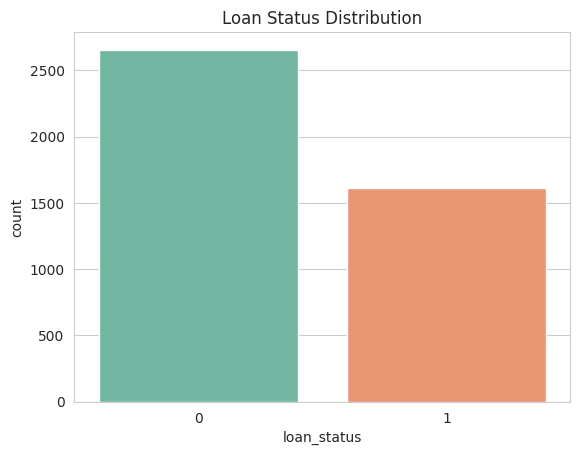

In [55]:
sns.countplot(data=df, x='loan_status', palette='Set2')
plt.title("Loan Status Distribution")
plt.show()

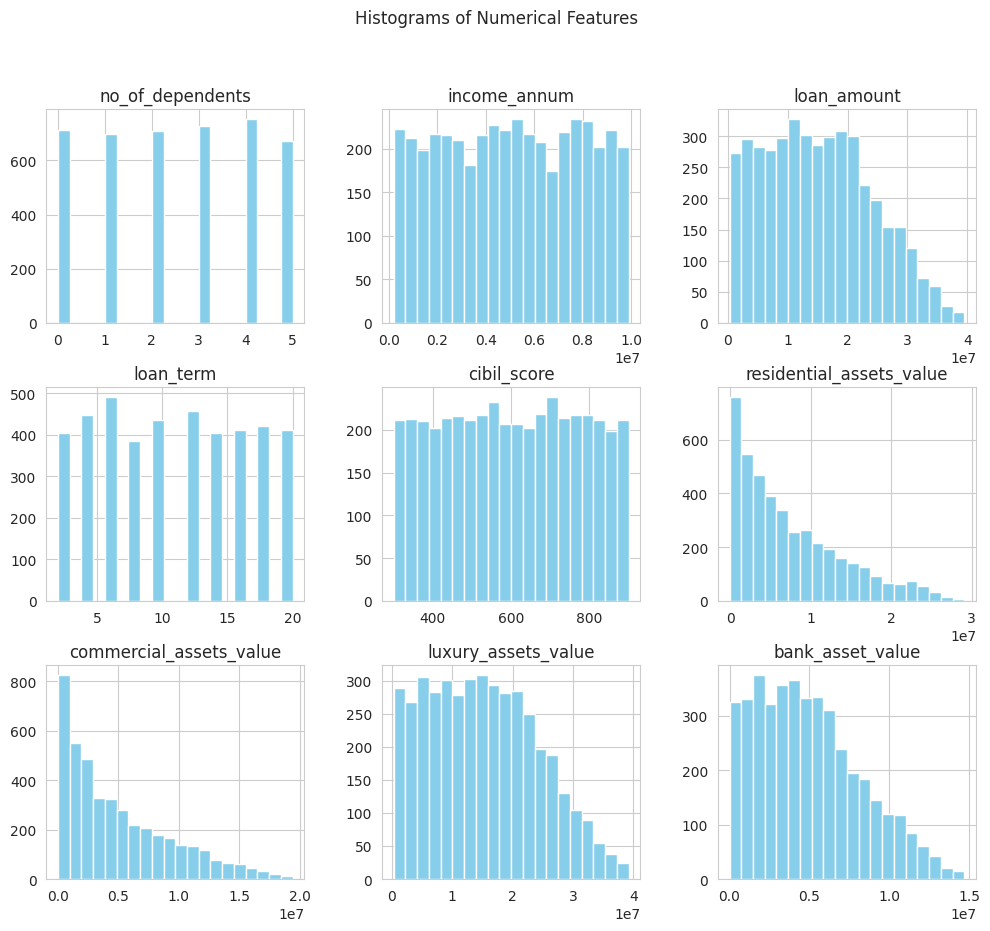

In [56]:
num_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
            'cibil_score', 'residential_assets_value', 'commercial_assets_value',
            'luxury_assets_value', 'bank_asset_value']

df[num_cols].hist(figsize=(12, 10), bins=20, color='skyblue')
plt.suptitle("Histograms of Numerical Features")
plt.show()

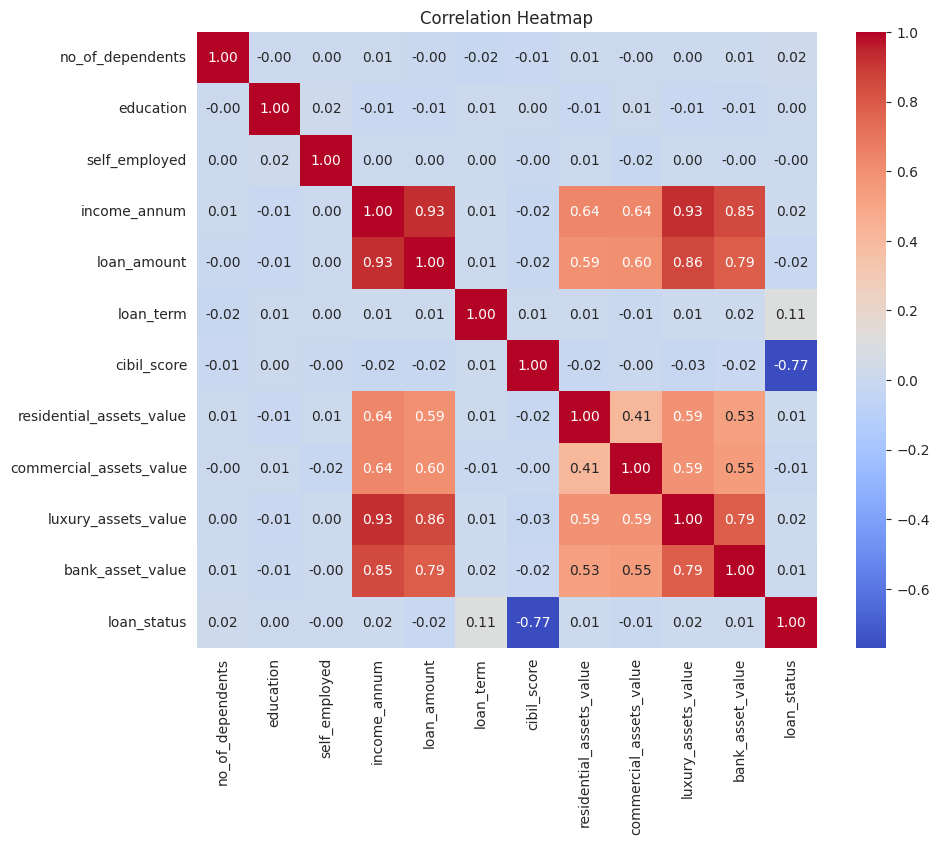

In [57]:

plt.figure(figsize=(10, 8))
corr = df.drop('loan_id', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [58]:
target_corr = corr["loan_status"].drop("loan_status").sort_values(ascending=False)
print("Top features correlated with loan_status:\n", target_corr)

Top features correlated with loan_status:
 loan_term                   0.113036
no_of_dependents            0.018114
luxury_assets_value         0.015465
income_annum                0.015189
residential_assets_value    0.014367
bank_asset_value            0.006778
education                   0.004918
self_employed              -0.000345
commercial_assets_value    -0.008246
loan_amount                -0.016150
cibil_score                -0.770518
Name: loan_status, dtype: float64


In [48]:

X = df.drop(['loan_id', 'loan_status'], axis=1)
y = df['loan_status']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [49]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)
print("Best RF Parameters:", grid_search_rf.best_params_)
print("Best RF Score:", grid_search_rf.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF Score: 0.9818448023426061


In [50]:

param_grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search_et = GridSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_grid_et,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_et.fit(X_train, y_train)
print("Best ET Parameters:", grid_search_et.best_params_)
print("Best ET Score:", grid_search_et.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ET Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best ET Score: 0.9636896046852123


In [51]:
param_grid_lr = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [100, 200]
}

grid_search_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression Score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Score: 0.9341142020497804


In [52]:
best_rf = grid_search_rf.best_estimator_
best_et = grid_search_et.best_estimator_
best_lr = grid_search_lr.best_estimator_

meta_learner = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', best_rf),
        ('et', best_et),
        ('lr', best_lr)
    ],
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

In [53]:
print("Meta Learner Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Meta Learner Accuracy: 0.9824
Confusion Matrix:
 [[527   4]
 [ 11 312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [54]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Rejected', 'Approved'],
    mode='classification'
)

index_to_explain = 0
data_row = X_test.iloc[index_to_explain]

print("True Label:", y_test.iloc[index_to_explain])
lime_exp = explainer.explain_instance(
    data_row.values,
    stacking_clf.predict_proba,
    num_features=10
)

lime_exp.show_in_notebook()

True Label: 0
